# Use Time Series Foundation Models and time series data to predict energy demand

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.
- Time Series Foundation Models are supported since CPD **5.1.1** release. 

## Notebook content

This notebook demonstrates the use of a pre-trained time series foundation model for multivariate forecasting tasks and showcases the variety of features available in Time Series Foundation Models.



Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goals

The learning goals of this notebook are:
-  To explore Time Series Foundation Models
-  To initialize the model
-  To forecast based on historical data


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Time series dataset](#dataset)
3.	[Time Series Foundation Models in watsonx.ai](#models)
4.	[Initialize the `TSModelInference` class.](#init)
5.	[Forecast](#forecast)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pak for Data administrator and ask them for your account credentials

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install -U matplotlib | tail -n 1
!pip install -U "ibm-watsonx-ai>=1.1.24" | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pak for Data. You need to provide platform `url`, your `username` and `api_key`.

In [2]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [3]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.1"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.1"
)

```

### Working with projects

First of all, you need to create a project that will be used for your work. If you do not have project already created follow below steps.

- Open IBM Cloud Pak main page
- Click all projects
- Create an empty project
- Copy `project_id` from url and paste it below

**Action**: Assign project ID below

In [4]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")

Create an instance of APIClient with authentication details.

In [5]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

To be able to interact with all resources available in WML services, you need to set the **project** which you will be using.

In [6]:
client.set.default_project(project_id)

'SUCCESS'

<a id="dataset"></a>
### Training dataset

This tutorial uses the [Hourly energy demand dataset](https://github.com/IBM/watson-machine-learning-samples/raw/refs/heads/master/cloud/data/energy/energy_dataset.csv) dataset, which contains four years of electrical consumption and generation data for Spain. It is a modified version of the [Hourly energy demand generation and weather](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather/data). For simplicity, the dataset has been prepared to have no missing values and no irrelevant columns."

In [7]:
import os, wget

filename = 'energy_dataset.csv'
base_url = 'https://github.com/IBM/watson-machine-learning-samples/raw/refs/heads/master/cloud/data/energy/'

if not os.path.isfile(filename): wget.download(base_url + filename)

In [8]:
import pandas as pd

df = pd.read_csv(filename)

Show the last few rows of the dataset.

In [9]:
df.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual
35059,2018-12-31 19:00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,96.0,3253.0,30619.0,30653.0
35060,2018-12-31 20:00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,51.0,3353.0,29932.0,29735.0
35061,2018-12-31 21:00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,36.0,3404.0,27903.0,28071.0
35062,2018-12-31 22:00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,93.0,31.0,287.0,3586.0,29.0,3273.0,25450.0,25801.0
35063,2018-12-31 23:00:00,290.0,0.0,6926.0,2166.0,163.0,108.0,1069.0,1686.0,6075.0,61.0,92.0,31.0,287.0,3651.0,26.0,3117.0,24424.0,24455.0


Describe the data.

In [10]:
df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.532797,448.091918,5622.705653,4256.550622,298.341319,475.563997,972.206337,2605.496121,6263.501854,60.225416,85.634326,1432.804957,269.419205,5465.115589,1439.066735,5471.216689,28712.129962,28697.608573
std,85.346455,354.616732,2201.557635,1961.973297,52.518371,792.291849,400.714694,1835.074561,840.244555,20.238846,14.076953,1680.007595,50.217172,3213.736451,1677.703355,3176.312853,4594.100854,4575.872425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,237.000000,18105.000000,18041.000000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1078.000000,5759.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,69.000000,2979.000000,24793.750000,24806.750000
50%,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2165.000000,6564.000000,57.000000,88.000000,616.000000,279.000000,4849.000000,576.000000,4855.000000,28906.000000,28902.000000
75%,433.000000,757.000000,6429.000000,5839.000000,330.000000,616.000000,1250.000000,3757.250000,7025.000000,80.000000,97.000000,2579.000000,310.000000,7399.500000,2636.000000,7353.000000,32263.250000,32194.250000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000


## Split the data
The purpose of this notebook is to demonstrate the core functionality of features available in Time Series Foundation Models. The selected model, `ibm/granite-ttm-512-96-r2`, requires a minimum context length of 512. Therefore, the dataset will be split into a historical dataset containing 512 rows, while the next 96 lines will be used to check the consistency of the predictions.

In [11]:
timestamp_column = "time"
target_column = "total load actual"
context_length = 608
future_context = 96

In [12]:
# Only use the last `context_length` rows for prediction.
future_data = df.iloc[-future_context:,]
data = df.iloc[-context_length:-future_context,]

### Visualize the data

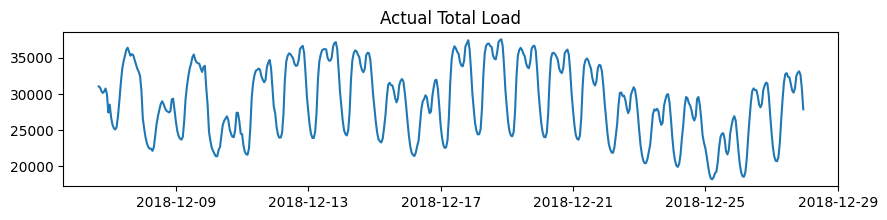

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,2))
plt.plot(np.asarray(data[timestamp_column], 'datetime64[s]'), data[target_column])
plt.title("Actual Total Load")
plt.show()

<a id="models"></a>
## Time Series Foundation Models in watsonx.ai

### List available models 


In [14]:
for model in client.foundation_models.get_time_series_model_specs()["resources"]:
    print('--------------------------------------------------')
    print(f'model_id: {model["model_id"]}')
    print(f'functions: {model["functions"]}')
    print(f'long_description: {model["long_description"]}')
    print(f'label: {model["label"]}')


--------------------------------------------------
model_id: ibm/granite-ttm-1024-96-r2
functions: [{'id': 'time_series_forecast'}]
long_description: TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. Given the last 1024 time-points (i.e. context length), this model can forecast up to next 96 time-points (i.e. forecast length) in future. This model is targeted towards a forecasting setting of context length 1024 and forecast length 96 and recommended for hourly and minutely resolutions (Ex. 10 min, 15 min, 1 hour, etc)
label: granite-ttm-1024-96-r2
--------------------------------------------------
model_id: ibm/granite-ttm-1536-96-r2
functions: [{'id': 'time_series_forecast'}]
long_description: TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. Given the last 1536 time-points (i.e. context length), this model can forecast up to next 96 tim

### Defining model
You need to specify `model_id` that will be used for inferencing:

In [15]:
ts_model_id = client.foundation_models.TimeSeriesModels.GRANITE_TTM_512_96_R2

<a id="init"></a>
## Initialize the `TSModelInference` class.

`TSModelInference` is a wrapper for time series models available from watsonx.ai, designed to forecast future values based on historical data.



In [16]:
from ibm_watsonx_ai.foundation_models import TSModelInference

ts_model = TSModelInference(
    model_id=ts_model_id,
    api_client=client
)

### Defining the model parameters
We need to provide a set of model parameters that will influence the result:

In [17]:
from ibm_watsonx_ai.foundation_models.schema import TSForecastParameters

forecasting_params = TSForecastParameters(
    timestamp_column=timestamp_column, 
    freq="1h", 
    target_columns=[target_column],
) 

<a id="forecast"></a>
## Forecasting

Call the `forecast()` method to predict electricity consumption.

In [18]:
results = ts_model.forecast(data=data, params=forecasting_params)['results'][0]

### Plot predictions along with the historical data.
 

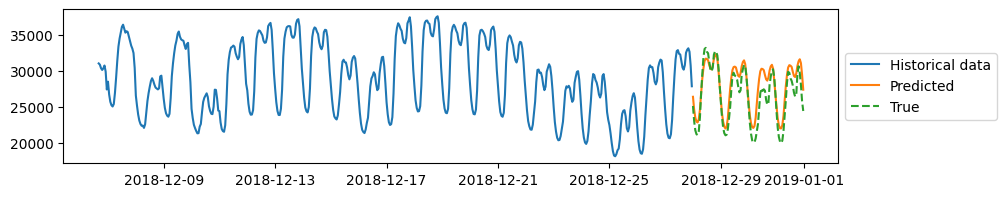

In [19]:
plt.figure(figsize=(10,2))
plt.plot(np.asarray(data[timestamp_column], dtype='datetime64[s]'), data[target_column], label="Historical data")
plt.plot(np.asarray(results[timestamp_column], dtype='datetime64[s]'), results[target_column], label="Predicted")
plt.plot(np.asarray(future_data[timestamp_column], dtype='datetime64[s]'), future_data[target_column], label="True", linestyle='dashed')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<a id="summary"></a>
## 8. Summary and next steps

 You successfully completed this notebook!
 
 You learned how to use Time Series Foundation Models in real life applications. 
 
 Check out our _[Online Documentation](https://ibm.github.io/watsonx-ai-python-sdk/samples.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Aleksandra Kłeczek**, Software Engineer at watsonx.ai.


Copyright © 2025 IBM. This notebook and its source code are released under the terms of the MIT License.